### Лабораторная работа №3
### DBSCAN

In [177]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans

matplotlib.style.use('ggplot')
%matplotlib inline

In [178]:
df = pd.read_csv("задача_1_леденцы/Леденцы.csv", sep=";")
print(df)

     V1  V2  V3  V4  V5  V6  V7  V8  V9  V10  V11
0     4   5   5   5   3   3   3   3   3    3    3
1     5   4   5   5   3   3   3   3   3    3    3
2     5   5   4   5   3   3   3   3   3    3    3
3     5   4   5   5   3   3   3   3   3    3    3
4     4   5   5   5   3   3   3   3   3    3    3
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...
333   3   3   3   3   3   3   5   5   3    3    3
334   3   3   3   3   3   3   5   5   3    3    3
335   3   3   3   3   3   3   5   5   3    3    3
336   3   3   3   3   3   3   5   5   3    3    3
337   3   3   3   3   3   3   5   5   3    3    3

[338 rows x 11 columns]


Воспользуемся сеткой, чтобы подобрать наилучшую с точки зрения силуэта кластеризацию. Возьмем число соседей в диапазоне от 15 до 25,
чтобы избежать излишне большого числа кластера, тяжело интерпретируемых с точки зрения бизнес-логики.

In [179]:
grid = ParameterGrid({'eps': [1.0, 1.5, 1.75, 2.3],
                      'min_samples': list(range(15, 25, 2))})
models = [DBSCAN(eps=parameter['eps'], metric='euclidean', min_samples=parameter['min_samples']).fit(df)
          for parameter in grid]
silhouette_values = [silhouette_score(df, model.labels_) for model in models]
parameters = [f"{parameter['eps']} {parameter['min_samples']} " for parameter in grid]
parameters[np.argmax(silhouette_values)]

'1.75 15 '

Построим график значений силуэта

Text(0, 0.5, 'Silhouette')

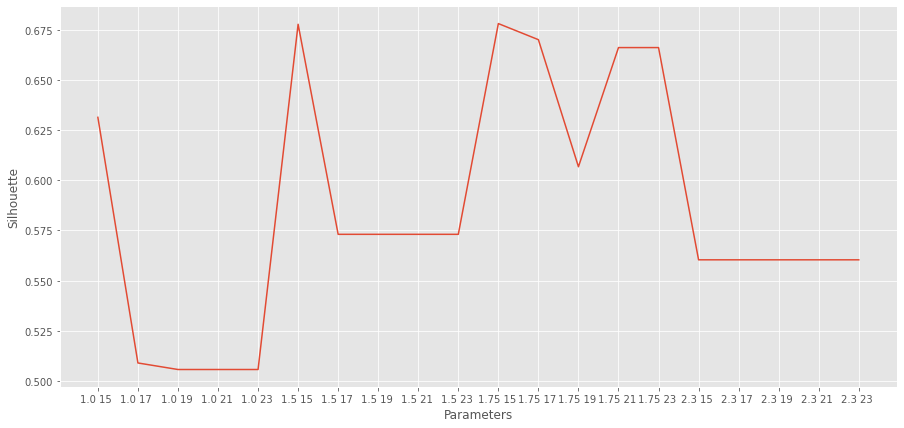

In [180]:
plt.figure(figsize=(15, 7))
plt.plot(parameters, silhouette_values)
plt.xlabel("Parameters")
plt.ylabel("Silhouette")

In [181]:
model = DBSCAN(eps=1.75, metric='euclidean', min_samples=15)
model.fit(df)
df['cluster'] = model.labels_

In [182]:
df.groupby('cluster').mean()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
cluster,,,,,,,,,,,
-1,2.200000,2.80,2.800000,2.800000,2.000000,2.200000,3.400000,3.800000,4.600000,4.400000,4.400000
0,4.845455,4.80,4.836364,4.681818,3.036364,3.036364,3.000000,2.990909,3.072727,3.045455,3.045455
1,2.890000,2.82,2.750000,2.590000,2.660000,2.630000,2.730000,2.870000,4.950000,4.820000,4.870000
2,3.000000,3.00,3.000000,3.000000,4.852459,4.852459,3.000000,2.918033,2.754098,2.754098,2.754098
3,3.000000,3.00,3.000000,2.947368,2.947368,2.947368,4.912281,4.912281,3.000000,3.000000,3.000000


In [183]:
df.groupby('cluster').median()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
cluster,,,,,,,,,,,
-1,2.0,2.0,2.0,2.0,2.0,2.0,4.0,4.0,5.0,5.0,5.0
0,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,5.0,5.0,5.0
2,3.0,3.0,3.0,3.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0
3,3.0,3.0,3.0,3.0,3.0,3.0,5.0,5.0,3.0,3.0,3.0


Сравним результаты с полученными в ходе кластеризации методом K-means.

In [184]:
model = KMeans(n_clusters=4, max_iter=300, n_init=10, verbose=0)
model.fit(df)
df['cluster1'] = model.labels_

In [185]:
tab = pd.crosstab(df['cluster1'], df['cluster'])

print(tab)

cluster   -1    0    1   2   3
cluster1                      
0          8    0  100   0   0
1          0    0    0  61   0
2          0  110    0   0   0
3          2    0    0   0  57


### Анализ и интерпретация результатов
В общем и целом данная кластеризация очень похожа на рассмотренные нами ранее. Приведем общую для них интерпретацию,
прежде чем говорить про отличия.

Перед тем, как приступать непосредственно к анализу данных, можно попробовать сгруппировать вопросы с близкой семантикой.
Так, первые четыре вопроса касаются свежести дыхания и полости рта, следующие два - вкусовых качеств, 7 и 8 - концентрации
или отвлечения внимания, а последние три - использования леденцов в лечебных целях.
Это же разбиение можно проследить и в данных. Рассмотрим медианные значения по ответам для получившихся кластеров.
К первому кластеру отнесены те респонденты, которые поставили наивысшую оценку "медицинским" вопросам.
В нулевом кластере оказались те участники, которые используют леденцы для освежения дыхания и полости рта.
Те голосовавшие, которые оказались в третьем кластере, любят леденцы за их сладость.
И наконец последний кластер объединяет тех людей, которые предпочитают использовать леденцы для того, чтобы отвлечь/сфокусировать свое внимание.

Для того, чтобы оценить различия получившихся кластеризаций, рассмотрим объекты с отличающимися кластерами.
Посмотрим медиану по тем объектам, которые переместились из кластера 0 в выбросы.

In [189]:
df[(df['cluster'] == -1) & (df['cluster1'] == 0)].median()

V1          2.0
V2          3.0
V3          3.0
V4          3.0
V5          2.0
V6          2.0
V7          3.0
V8          3.5
V9          5.0
V10         5.0
V11         5.0
cluster    -1.0
cluster1    0.0
dtype: float64

Посмотрим медиану по тем объектам, которые переместились из кластера 3 в выбросы.

In [190]:
df[(df['cluster'] == -1) & (df['cluster1'] == 3)].median()

V1          3.0
V2          2.0
V3          2.0
V4          2.0
V5          2.0
V6          3.0
V7          5.0
V8          5.0
V9          3.0
V10         3.0
V11         3.0
cluster    -1.0
cluster1    3.0
dtype: float64

К выбросам были причислены ответы тех респондентов из "медицинского" кластера, которые активно ставили "двойки" другим
пунктам. Та же ситуация и с респондентами из третьего кластера.

В целом кластеризация почти полностью согласуется с результатами, полученными нами на предыдущих шагах.  